# Individual Assignment - Submission

> - **Course:** *CE/CZ 4042 - Neural Networks and Deep Learning* 
> - **Name:** *Singh Aishwarya*
> - **Matriculation Number:** *U1923952C*
> - **Part:** *A - Classification Problem*
> - **Question:** *2*

### Necessary Imports

In [1]:
# Basic Helper Libraries
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Libraries for plotting and visualization
import pylab as plt
import matplotlib.pyplot as matplt

### Data Retrieval + Train-Test Split

In [2]:
# Accessing the features data in the csv file and assigning it to a dataframe
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# Check the value count of the output
df['label'].value_counts()

metal        100
blues        100
disco        100
pop          100
jazz         100
classical    100
rock         100
hiphop       100
country      100
reggae       100
Name: label, dtype: int64

In [4]:
# Prepare Train and Test Dataframes
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # Divide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    # Scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
# Splitting the prepared dataframes (70% Training and 30% Test)
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


### Model Training - Answering the question

> **Question:** *In this question, we will compare the performance of the model **using stochastic gradient descent** and **mini-batch gradient descent**, as well as determining the **optimal batch size** for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. **Note: Use 3-fold cross-validation on training partition to perform parameter selection**.*

In [6]:
# Setting the given parameters for the model
num_epochs = 50
num_hidden = 16
num_labels = 10
num_features = 57

# Array to hold different batch sizes
batch_size = [1,4,8,16,32,64]

# Array to hold mean accuracies
mean_acc = [] 

# Array to hold median time
median_time = []

# K-Fold splitting to use 3-fold cross-validation 
splits = KFold(n_splits = 3, random_state = 1, shuffle = True)

In [7]:
# Callback function for calculating median time
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [15]:
# Hold accuracies
cv = []

# Iterate through array of batch sizes and train different models
for batch in batch_size:
    
    # Array to hold accuracy for 1 batch size
    acc = []
    
    # Array to hold time for 1 batch size
    med_time = []
    
    # Declare variable for keeping count of folds
    fold = 0
    
    for train, test in splits.split(X_train, y_train):
        
        # Call the callback function to measure time
        cb = TimingCallback()
        
        # Designing the model with the given parameters
        model = Sequential()
        model.add(Dropout(0.3))
        model.add(Dense(num_hidden, activation='relu'))
        model.add(Dense(num_labels, activation='softmax'))
        
        # Setting the loss to sparse_categorical_crossentropy as this is a classification problem
        model.compile(optimizer='sgd',
                      loss='sparse_categorical_crossentropy',
                      metrics = ['accuracy'])
        
        # Training the model
        history = model.fit(X_train[train], y_train[train], 
                            epochs=num_epochs, 
                            batch_size=batch, 
                            callbacks = [cb],
                            verbose = 0,
                            validation_data=(X_train[test], y_train[test]))
        
        # Append the accuracy for the epoch for the current batch size
        acc.append(history.history['val_accuracy'][num_epochs-1])
        cv.append(history.history['val_accuracy'])
        
        # Append the median time for epochs for the current batch size
        med_time.append(np.median(cb.times))
        
        print('Batch Size: %d | Fold %d | Train Accuracy %g'%(batch, fold + 1, acc[fold]))
        fold += 1
        
    # Calculate mean cross-validation accuracy
    mean_acc.append(np.mean(acc))
    print('Mean 3-fold Cross Validation Accuracy = %g'% np.mean(acc))
    
    # Calculate median time
    median_time.append(np.median(med_time))
    
    print('Median Time for Batch Size %d: %g s'%(batch, np.median(cb.times)))
    print('--------------------------------------------------------------------------------')

Batch Size: 1 | Fold 1 | Train Accuracy 0.692308
Batch Size: 1 | Fold 2 | Train Accuracy 0.67382
Batch Size: 1 | Fold 3 | Train Accuracy 0.639485
Mean 3-fold Cross Validation Accuracy = 0.668537
Median Time for Batch Size 1: 0.31421 s
--------------------------------------------------------------------------------
Batch Size: 4 | Fold 1 | Train Accuracy 0.675214
Batch Size: 4 | Fold 2 | Train Accuracy 0.660944
Batch Size: 4 | Fold 3 | Train Accuracy 0.690987
Mean 3-fold Cross Validation Accuracy = 0.675715
Median Time for Batch Size 4: 0.0985371 s
--------------------------------------------------------------------------------
Batch Size: 8 | Fold 1 | Train Accuracy 0.628205
Batch Size: 8 | Fold 2 | Train Accuracy 0.665236
Batch Size: 8 | Fold 3 | Train Accuracy 0.660944
Mean 3-fold Cross Validation Accuracy = 0.651462
Median Time for Batch Size 8: 0.061228 s
--------------------------------------------------------------------------------
Batch Size: 16 | Fold 1 | Train Accuracy 0.5897

#### a) Plot mean cross-validation accuracies over the training epochs for different batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.

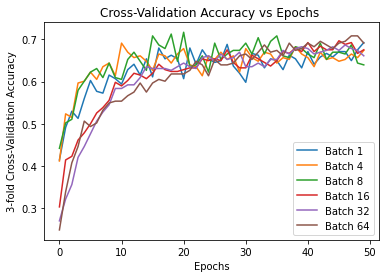

In [19]:
# Plot to visualise the mean cross-validation accuracy for different batch sizes
# Batch Size 1
y1 = cv[0]
matplt.plot(y1, label = "Batch 1")

# Batch Size 4
y2 = cv[1]
matplt.plot(y2, label = "Batch 4")

# Batch Size 8
y3 = cv[2]
matplt.plot(y3, label = "Batch 8")

# Batch Size 16
y4 = cv[3]
matplt.plot(y4, label = "Batch 16")

# Batch Size 32
y5 = cv[4]
matplt.plot(y5, label = "Batch 32")

# Batch Size 64
y6 = cv[5]
matplt.plot(y6, label = "Batch 64")

plt.xlabel('Epochs')
plt.ylabel('3-fold Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs Epochs ')
plt.legend()
plt.savefig('./Figures/PartAQuestion2-1.png')

#### b) Create a table of median time taken to train the network for one epoch against different batch sizes. Hint: Introduce a callback

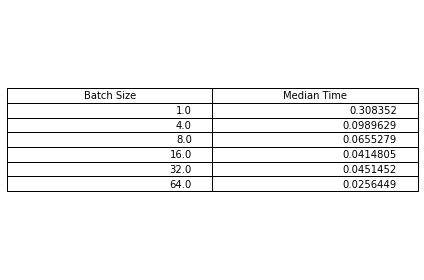

In [ ]:
data=[[1,0.308352],
      [4,0.0989629],
      [8,0.0655279],
      [16,0.0414805],
      [32,0.0451452],
      [64,0.0256449]]
column_labels=["Batch Size", "Median Time"]
fig, ax = matplt.subplots()

# Hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(data, columns=column_labels)
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
matplt.show()

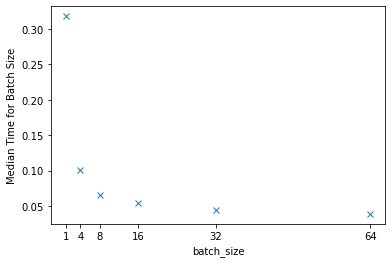

In [ ]:
# Plot to visualise change in median time for different batch sizes
plt.plot(batch_size, median_time, marker = 'x', linestyle = 'None')
plt.xticks([1, 4, 8, 16, 32, 64])
plt.xlabel('batch_size')
plt.ylabel('Median Time for Batch Size')
plt.savefig('./Figures/PartAQuestion2-2.png')

#### c) Select the optimal batch size and state reasons for your selection.

> **Optimal Batch Size:** *Based on both the accuracy and median time plots, the optimal batch size should be **8** - the closest trade-off between time and accuracy for the model that has been trained with the given parameters*

#### d) What is the difference between mini-batch gradient descent and stochastic gradient descent and what does this mean for model training?

> **Stochastic Gradient Descent:** *Deep Learning models work better with more data - the more data it is fed, the higher the better the model performs. In Gradient Descent, the model will need to compute the gradients of all data points in only one step. This does not appear to be an efficient method. Stochastic Gradient Descent is a solution to this problem. To perform a single step in Stochastic Gradient Descent (SGD), we evaluate only one sample at a time. In one epoch, data point is taken and fed to Neural Network, gradient is calculated, update weights and repeat for all data points. Because we are only evaluating one example at a time, the cost will vary among the training instances and will not always decrease. However, in the long run, the cost will decrease with fluctuations. Also, because the cost is so volatile, it will never hit the minimum but will continue to bounce around it. For bigger datasets, SGD can be utilized. When the dataset is large, it converges quicker since the parameters are updated more frequently.*

> **Mini-Batch Gradient Descent:** *For bigger datasets, SGD converges quicker. However, because SGD only uses one example at a time, we cannot utilize the vectorized implementation on it. This can cause the computations to slow down. To address this issue, a combination of Batch Gradient Descent and SGD is utilized. We do not utilize the entire dataset at once, nor do we use a single sample at a time. A mini-batch is a batch of a predetermined number of training samples that is smaller than the full dataset. The average cost over the epochs in mini-batch gradient descent swings similarly to SGD since we are averaging a limited number of instances at a time. So, when we utilize mini-batch gradient descent, we regularly update our parameters and may use vectorized implementation for quicker computations.*

#### e) Plot the train and test accuracies against epochs for the optimal batch size.

In [ ]:
for train, test in splits.split(X_train, y_train):
        
    # Designing the model with the given parameters
    model = Sequential()
    model.add(Dropout(0.3))
    model.add(Dense(num_hidden, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))
        
    # Setting the loss to sparse_categorical_crossentropy as this is a classification problem
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
        
    # Training the model with batch size = 8
    history = model.fit(X_train[train], y_train[train], 
                        epochs=num_epochs, 
                        batch_size=8, 
                        callbacks = [cb],
                        verbose = 0,
                        validation_data=(X_train[test], y_train[test]))

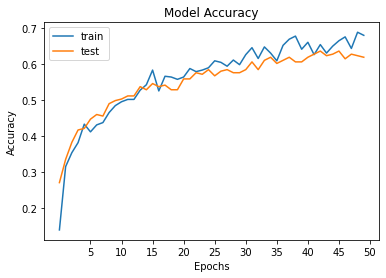

In [ ]:
# Plot the train and test accuracies for batch size 8
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./Figures/PartAQuestion2-3.png')

### Conclusion
> From Question 1, the observable gap between the train and test plots has reduced significantly, thus addressing the problem of overfitting. The parameter tuning for batch size selection using 3-fold cross validation has slightly improved the model.